In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np 
import os 
import sys
import tarfile
import random
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

%matplotlib inline

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.'


def download_progress_hook(count, blockSize , totalSize):
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)
    
    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
            
    last_percent_reported = percent
    
def maybe_download(filename,expected_bytes, force = False):
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename)
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified',dest_filename)
    else:
        raise Exception(
            'Failed to verify' + dest_filename + '. Can you get to it with a browser ? ')
        return dest_filename
    
train_filename = maybe_download('notMNIST_large.tar.gz',247336696)
train_directoryName = 'notMNIST_large.tar.gz'
test_filename = maybe_download('notMNIST_small.tar.gz',8458043)
test_directoryName = 'notMNIST_small.tar.gz'

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


In [3]:
num_classes = 10
np.random.seed(133)

print(train_directoryName)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
print (train_filename)
train_folders = maybe_extract(train_directoryName)
test_folders = maybe_extract(test_directoryName)

notMNIST_large.tar.gz
None
notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


In [4]:
image_size = 28 #Pixel width and height.
pixel_depth = 255.0

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
                            
                            
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_small/D.pickle already present - Skipping pickling.
notMNIST_small/E.pickle already present - Skipping pickling.
notMNIST_small/F.pickle already present - Skipping pickling.
notMNIST_small/G.pickle 

In [5]:
base_dir = os.getcwd() +"/notMNIST_large/"
letters = [chr(ord('A') + i) for i in range(0,10) ]
for letter in letters:
               letter_dir = base_dir + letter
               random_image = random.choice(os.listdir(letter_dir))
               display(Image(filename= letter_dir+ '/'+ random_image))
               print(letter)

A


B


C


D


E


F


G


H


I


J


In [6]:
for i in range(len(train_datasets)):
    print(pickle.load(open(train_datasets[i],"rb")).shape)


(52909, 28, 28)
(52911, 28, 28)
(52912, 28, 28)
(52911, 28, 28)
(52912, 28, 28)
(52912, 28, 28)
(52912, 28, 28)
(52912, 28, 28)
(52912, 28, 28)
(52911, 28, 28)


In [7]:
print("Test datasets")
for i in range(len(test_datasets)):
    print(pickle.load(open(test_datasets[i],"rb")).shape)

Test datasets
(1872, 28, 28)
(1873, 28, 28)
(1873, 28, 28)
(1873, 28, 28)
(1873, 28, 28)
(1872, 28, 28)
(1872, 28, 28)
(1872, 28, 28)
(1872, 28, 28)
(1872, 28, 28)


In [8]:
def is_balanced(datasets):
    dataset_shapes =[]
    for dataset_name in datasets:
        with open(dataset_name,'rb') as f:
            dataset = pickle.load(f)
            dataset_shapes.append(dataset.shape)
            print(dataset_name , 'Full dataset tensor:',dataset.shape)
            f.close()
            print ('Mean:', np.mean(dataset_shapes, axis=0))
            print('Standard deviation:', np.std(dataset_shapes, axis=0))
            
is_balanced(train_datasets)
is_balanced(test_datasets)

notMNIST_large/A.pickle Full dataset tensor: (52909, 28, 28)
Mean: [  5.29090000e+04   2.80000000e+01   2.80000000e+01]
Standard deviation: [ 0.  0.  0.]
notMNIST_large/B.pickle Full dataset tensor: (52911, 28, 28)
Mean: [  5.29100000e+04   2.80000000e+01   2.80000000e+01]
Standard deviation: [ 1.  0.  0.]
notMNIST_large/C.pickle Full dataset tensor: (52912, 28, 28)
Mean: [  5.29106667e+04   2.80000000e+01   2.80000000e+01]
Standard deviation: [ 1.24721913  0.          0.        ]
notMNIST_large/D.pickle Full dataset tensor: (52911, 28, 28)
Mean: [  5.29107500e+04   2.80000000e+01   2.80000000e+01]
Standard deviation: [ 1.08972474  0.          0.        ]
notMNIST_large/E.pickle Full dataset tensor: (52912, 28, 28)
Mean: [  5.29110000e+04   2.80000000e+01   2.80000000e+01]
Standard deviation: [ 1.09544512  0.          0.        ]
notMNIST_large/F.pickle Full dataset tensor: (52912, 28, 28)
Mean: [  5.29111667e+04   2.80000000e+01   2.80000000e+01]
Standard deviation: [ 1.06718737  0.  

Problem 2 


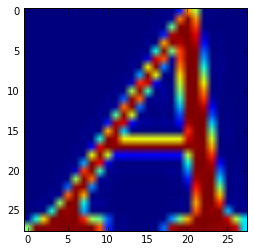

In [9]:
A_list = pickle.load(open("notMNIST_large/A.pickle", "rb"))
random_letter = random.choice(A_list)
%matplotlib inline
plt.imshow(random_letter)

letter_dir: notMNIST_large/A.pickle
A


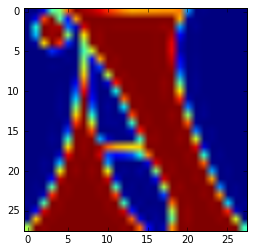

letter_dir: notMNIST_large/B.pickle
B


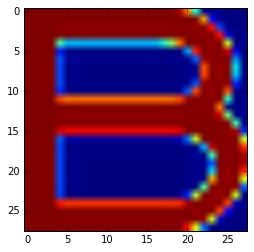

letter_dir: notMNIST_large/C.pickle
C


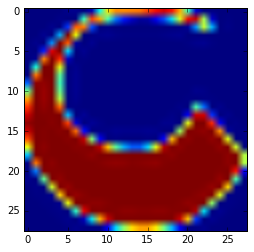

letter_dir: notMNIST_large/D.pickle
D


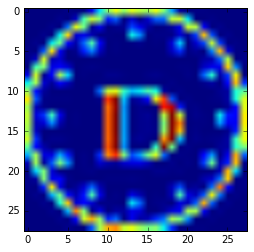

letter_dir: notMNIST_large/E.pickle
E


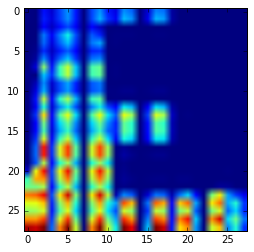

letter_dir: notMNIST_large/F.pickle
F


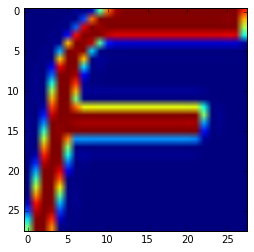

letter_dir: notMNIST_large/G.pickle
G


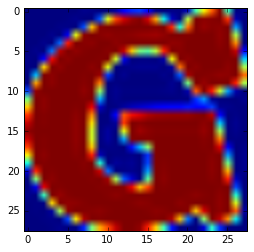

letter_dir: notMNIST_large/H.pickle
H


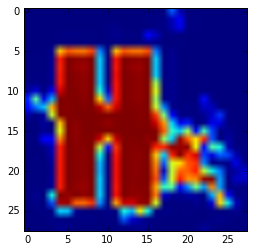

letter_dir: notMNIST_large/I.pickle
I


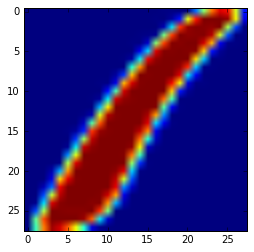

letter_dir: notMNIST_large/J.pickle
J


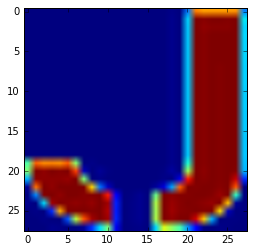

In [10]:
def renderLetter(random_letter):            
    %matplotlib inline
    plt.figure()
    plt.imshow(random_letter)
    plt.show()



base_dir = os.getcwd() +"/notMNIST_large/"
letters = [chr(ord('A') + i) for i in range(0,10) ]

for letter in letters:
               letter_dir = "notMNIST_large/" + letter +".pickle"
               print("letter_dir: "+letter_dir)
               char_pickle = pickle.load(open(letter_dir,"rb"))
               random_letter = random.choice(char_pickle)
               #%matplotlib inline
               #plt.figure()
               #plt.imshow(random_letter)
               print(letter)
               renderLetter(random_letter)
            

Problem 3 

In [11]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [12]:
letters = [chr(ord('A') + i) for i in range(0,10) ]
for letter in letters:
    letter_train_data = pickle.load(open('notMNIST_large/' + letter + '.pickle', "rb"))
    print(letter + " train data count : " + str(len(letter_train_data)) )
    letter_test_data = pickle.load(open('notMNIST_small/' + letter + '.pickle', "rb"))
    print(letter + " test data count : " + str(len(letter_test_data)) )

A train data count : 52909
A test data count : 1872
B train data count : 52911
B test data count : 1873
C train data count : 52912
C test data count : 1873
D train data count : 52911
D test data count : 1873
E train data count : 52912
E test data count : 1873
F train data count : 52912
F test data count : 1872
G train data count : 52912
G test data count : 1872
H train data count : 52912
H test data count : 1872
I train data count : 52912
I test data count : 1872
J train data count : 52911
J test data count : 1872


In [13]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)


In [14]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [15]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441


In [16]:
import hashlib 
all_data = pickle.load(open('notMNIST.pickle', 'rb'))

def count_duplicates(dataset1, dataset2):
    hashes = [hashlib.sha1(x).hexdigest() for x in dataset1]
    dup_indices = []
    for i in range(0, len(dataset2)):
        if hashlib.sha1(dataset2[i]).hexdigest() in hashes:
            dup_indices.append(i)
    return len(dup_indices)


print(count_duplicates(all_data['test_dataset'], all_data['valid_dataset']))
print(count_duplicates(all_data['valid_dataset'], all_data['train_dataset']))
print(count_duplicates(all_data['test_dataset'], all_data['train_dataset']))


153
3627
3622
